<a href="https://colab.research.google.com/github/DPGGES/TensorFlow2.Notebooks/blob/main/Img_classification_TF2_Rocole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using TensorFlow v2.



This tutorial will explain the complete pipeline from loading data from several sources to predicting results. This is a tutorial to build an image classification model from scratch using TensorFlow v2. 

This tutorial will explain how to use GPU efficiently, load image data, build and train a convolution neural network... Data augmentation is  included in the model.

Make sure to change the Accelerator on the right to GPU.

The **objectives** of this tutorial will be:
* The tutorial is intended to be a first contact with the RoCoLe dataset.
* Create an input pipeline from different input sources, images and Excel file, using TensorFlow tools.
* Use a predefined model as feature extractor(ResNet101V2 & MobileNetV2) and own binary classifier.
* Diagnose deep learning model performance using learning curves.

# 1.Installs

In [ ]:
!pip install xlrd>=1.3.0
!pip install openpyxl

# 2.Imports

In [ ]:
try:
    %tensorflow_version 2.x

except Exception:
    pass

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

import itertools

print('Tensorflow version : {}'.format(tf.__version__))

tf.keras.backend.clear_session()
tf.executing_eagerly()==True

Tensorflow version : 2.4.1


True

# 3.Selecting Between Strategies

##3.1.CPU or GPU detection

Depending on the hardware available, we will use different distribution strategies. For this version we will use GPU or CPU. 
- If more than one GPU is available, then you'll use the Mirrored Strategy
- If one GPU is available or if just the CPU is available, you'll use the default strategy.

In [ ]:
# Detect hardware
try:
    gpus = tf.config.experimental.list_logical_devices("GPU")
except ValueError:
    gpu = 0
    
# Select appropriate distribution strategy
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


# 4.Global Parameters

The global BATCH_SIZE variable is the batch size per replica times the number of replicas in the distribution strategy.

In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.

In [ ]:

IMAGE_SIZE=224
CLASS_NAMES=[]
IMG_COUNT=0
num_classes=0

data_url ="https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/c5yvn32dzg-2.zip"
name_file="coffee.zip"

MAIN_IMG_DIR = '/root/.keras/datasets/Photos'
MAIN_ANN_DIR = '/root/.keras/datasets/Annotations'



# 5.Loading and Preprocessing the Dataset

## 5.1 RoCoLe: A robusta coffee leaf images dataset

 **RoCoLe**

https://data.mendeley.com/datasets/c5yvn32dzg/2

There are two main directories:


*   Photos: contains 1560 coffee leaf images (.jpg)
*   Annotations:  Segmentation, Classification etc.




In [ ]:
raw_dir=tf.keras.utils.get_file(fname=name_file, origin=data_url,extract=True)
!ls "/root/.keras/datasets/"

Annotations  coffee.zip  Photos


In [ ]:
data_dir = pathlib.Path(MAIN_IMG_DIR)
print("Directory:", data_dir)
IMG_COUNT = len(list(data_dir.glob('*.jpg')))
print("Number of images:",IMG_COUNT)

Directory: /root/.keras/datasets/Photos
Number of images: 1560


As you can see it is a small dataset composed by 1560 pictures of coffee leaf images. Beause of that, we are going  to perform a binary classification.
Also, the data is divided in several inputs : 
* Images files  
* xlsx files.

In [ ]:
#We need to use the file where classes are described:
!ls /root/.keras/datasets/Annotations

RoCoLe-classes.xlsx  RoCoLE-csv.csv    RoCoLe-voc.tar.gz
RoCoLE-coco.json     RoCoLE-json.json


We cannot created a tf.data.Dataset from image files in a directory since the information is separated in two different directories and files. 

Therefore, we will create a dataset containing location and tagging information using Pandas. Then, we will convert it into a shuffle dataset (from tensor slices). Finally we will create the dataset with the processed images.

## 5.1. Explore data

We want to perform a binary classification, so we are going to drop unnecessary information. As we can see, Multiclass label shall be removed.

In [ ]:
df = pd.read_excel(MAIN_ANN_DIR+'/RoCoLe-classes.xlsx',engine='openpyxl')
df.head()

,File,Binary.Label,Multiclass.Label
0,C1P1H1.jpg,healthy,healthy
1,C1P2E2.jpg,unhealthy,rust_level_2
2,C1P2H1.jpg,healthy,healthy
3,C1P3E1.jpg,healthy,healthy
4,C1P3E2.jpg,unhealthy,rust_level_2


In [ ]:
df.drop(['Multiclass.Label'], axis=1, inplace=True)
df.rename(columns={'Binary.Label':'Label'},inplace=True)

Run the following cell to see how many healthy/unhealthy pictures we have .

In [ ]:
#How many Labels has Multiclass.Label? R: 6
#How many Labels has Binary.Label? R: 2
num_classes=df.drop_duplicates(subset = ["Label"]).count()["Label"]
print("Number of Labels(in Binary.Label  column): "+ str(num_classes))
df.drop_duplicates(subset = ["Label"])

check_imbalance = df.pivot_table(index=['Label'], aggfunc='size')
print (check_imbalance)


Number of Labels(in Binary.Label  column): 2
Label
healthy      791
unhealthy    769
dtype: int64


Notice that the there are a little more images that are classified as healthy than unhealthy. However, this not shows that we have big imbalance in our data, because the diference between healthy and unhealthy is only 22 images.

Let's change the Label column from string to integer. Also, we are going to create a dictionary of Words, we will use this latter.

In [ ]:
CLASS_NAMES = (pd.Series.to_string(df.drop_duplicates(subset = ["Label"])["Label"],index=False).strip()).split()
CLASS_NAMES.sort()
print(CLASS_NAMES)

['healthy', 'unhealthy']


In [ ]:
dictOfWords = { CLASS_NAMES[i]:i for i in range(0, len(CLASS_NAMES))}
dictOfWords

{'healthy': 0, 'unhealthy': 1}

In [ ]:
df["Label"] = df["Label"].map(dictOfWords)
df

,File,Label
0,C1P1H1.jpg,0
1,C1P2E2.jpg,1
2,C1P2H1.jpg,0
3,C1P3E1.jpg,0
4,C1P3E2.jpg,1
...,...,...
1555,C12P40E2.jpg,1
1556,C12P40H1.jpg,0
1557,C12P40H2.jpg,1
1558,C8P24E2.jpg,1


## 5.2. Process Data

### 5.2.1.Load Pandas Dataframe as ShuffleDataset

Define 2 dataset:

* train_ds = the training set, 80%.
* val_ds    = the validation set, 20%.

Test dataset is not available because we are going to use the 20% percent to create the validation dataset.


In [ ]:
target = df.pop('Label')
dir_img=MAIN_IMG_DIR+'/{}'
df=df.applymap(dir_img.format)


dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))
dataset = dataset.shuffle(IMG_COUNT, reshuffle_each_iteration=False)

val_size = int(IMG_COUNT * 0.20)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(int(val_size))


train_size=tf.data.experimental.cardinality(train_ds).numpy()
val_size=tf.data.experimental.cardinality(val_ds).numpy()

print("Training size: {}".format(train_size))
print("Validation size: {}".format(val_size))
print("Total images: ",train_size+val_size)
print("\nExample: ")
for feat, targ in train_ds.take(5):
    print ('Image: {}, Label: {}'.format(feat, targ))

Training size: 1248
Validation size: 312
Total images:  1560

Example: 
Image: [b'/root/.keras/datasets/Photos/C1P11H1.jpg'], Label: 0
Image: [b'/root/.keras/datasets/Photos/C12P30H2.jpg'], Label: 1
Image: [b'/root/.keras/datasets/Photos/C9P36E2.jpg'], Label: 0
Image: [b'/root/.keras/datasets/Photos/C9P5H2.jpg'], Label: 0
Image: [b'/root/.keras/datasets/Photos/C10P15H1.jpg'], Label: 0


### 5.2.2.Configure dataset and Performance
Define some helper functions that will pre-process our data:

* parse_image: load,decode,convert...an image.
* get_training_dataset: loads data and splits it to get the training set.
* get_validation_dataset: loads and splits the data to get the validation set.

In [ ]:
'''
Transforms each image in dataset 
'''

def parse_image(feat, targ):

    image = tf.io.read_file(feat[0])
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # image pretreatment 
    image = tf.image.resize(image, [1512, 1512])
    image =  tf.image.central_crop(image, central_fraction=0.65)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]) 
  
    label= tf.cast(targ,tf.int32)

    return image, label
'''
Loads and maps the training split of the dataset using the map function. 
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_training_dataset():

      with  strategy.scope():
        dataset = train_ds.map(parse_image, num_parallel_calls=16)
        dataset = dataset.shuffle(buffer_size=train_size,
                                  reshuffle_each_iteration=True)
        dataset = dataset.repeat() 
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(AUTOTUNE) 
        return dataset

'''
Loads and maps the validation split of the dataset using the map function. 
'''  
def get_validation_dataset():

    dataset = val_ds.map(parse_image, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
    dataset = dataset.shuffle(buffer_size=train_size, 
                              reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

# instantiate the datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

### 5.2.3.Visualize

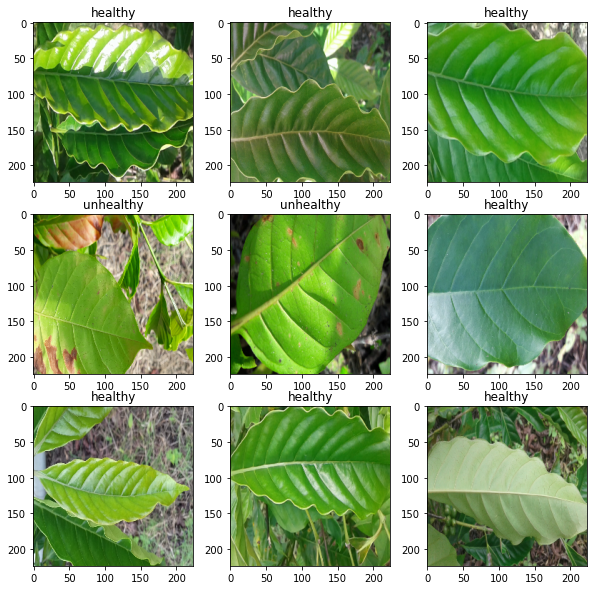

In [ ]:
image_batch, label_batch = next(iter(training_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    #index = tf.argmax(label.numpy(), axis=0)
    plt.title(CLASS_NAMES[label])


# 6.Models

We will use two predefined models, which we will use the weights provided with imagenet and we will not re-train the feature extraction layer. 

## 6.1.Utilities and model variables

In [ ]:
#Training variables
EPOCHS = 100
steps_per_epoch = (train_size)//BATCH_SIZE 
validation_steps = (val_size)//BATCH_SIZE 
IMG_DIM=(IMAGE_SIZE,IMAGE_SIZE)

In [ ]:
#Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
# Plotting Training and Validation Accuracy
def plot_history(hist,Text):
  history=hist
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(len(history.epoch))

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.plot(epochs_range,acc,label="Train Accuracy")
  plt.plot(epochs_range,val_acc,label="Validation Accuracy")
  plt.legend(loc = 'lower right')
  plt.title("Accuracy")
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label="Train Loss")
  plt.plot(epochs_range,val_loss,label="Validation Loss")
  plt.legend(loc = 'upper right')
  plt.title("Loss")
  plt.suptitle(Text)

## 6.2.ResNet101V2

Our model has the following sequential structure:

Data augmentation -> Feature extractor (resnet) -> Binary clasification

### 6.2.1.Define model

In [ ]:
IMG_DIM=(IMAGE_SIZE,IMAGE_SIZE)
def make_model():
    data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # 128x128x3
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_SIZE, 
                                                              IMAGE_SIZE,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("vertical", 
                                                 input_shape=(IMAGE_SIZE, 
                                                              IMAGE_SIZE,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.80)
    ])
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=(*IMG_DIM, 3),
                                             include_top=False,
                                             weights= 'imagenet')
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        data_augmentation, 
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.Dense(512, activation="relu" ),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.BatchNormalization(),
         tf.keras.layers.Dense(num_classes-1,activation="sigmoid")
])
        
    return model

### 6.2.2.Compile model

In [ ]:
with strategy.scope():
    model = make_model()
    model.compile(loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

### 6.2.3.Train model

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("RN101v2.h5",
                                                save_best_only=True)
history1 = model.fit(training_dataset,steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data = validation_dataset, validation_steps=validation_steps, 
                    batch_size=BATCH_SIZE, 
                     callbacks=[checkpoint, early_stopping,lr_scheduler])

Epoch 1/100
19/19 [==============================] - 187s 6s/step - loss: 0.9452 - accuracy: 0.5495 - val_loss: 0.9233 - val_accuracy: 0.6875
Epoch 2/100
19/19 [==============================] - 103s 6s/step - loss: 0.6478 - accuracy: 0.6241 - val_loss: 1.5514 - val_accuracy: 0.4570
Epoch 3/100
19/19 [==============================] - 105s 6s/step - loss: 0.5960 - accuracy: 0.6845 - val_loss: 0.6289 - val_accuracy: 0.7383
Epoch 4/100
19/19 [==============================] - 97s 5s/step - loss: 0.5759 - accuracy: 0.6846 - val_loss: 0.4102 - val_accuracy: 0.7891
Epoch 5/100
19/19 [==============================] - 96s 5s/step - loss: 0.6111 - accuracy: 0.6864 - val_loss: 0.5391 - val_accuracy: 0.7500
Epoch 6/100
19/19 [==============================] - 97s 5s/step - loss: 0.5206 - accuracy: 0.7319 - val_loss: 0.3788 - val_accuracy: 0.8242
Epoch 7/100
19/19 [==============================] - 97s 5s/step - loss: 0.5069 - accuracy: 0.7319 - val_loss: 0.5630 - val_accuracy: 0.7539
Epoch 8/10

### 6.2.4.Plot results

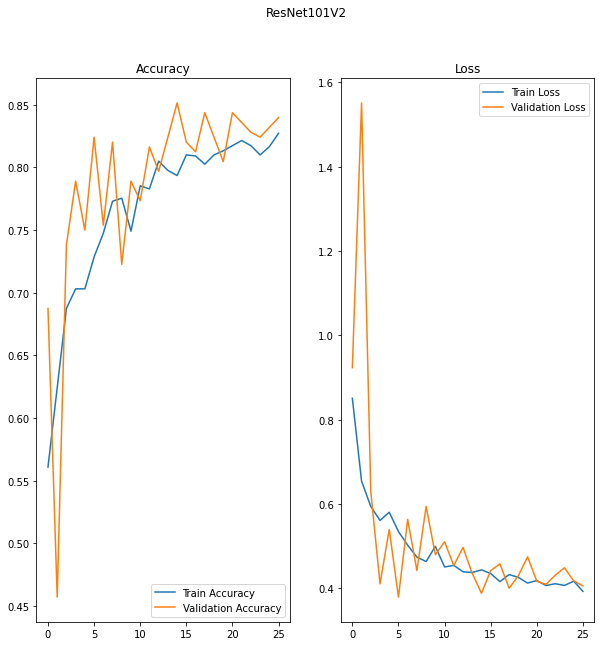

In [ ]:
# Plotting Training and Validation Accuracy
plot_history(history1,"ResNet101V2")


## 6.3.MobileNetV2

Our model has the following sequential structure:

Data augmentation -> Feature extractor (MobileNetV2) -> Binary clasification

### 6.3.1.Define model

In [ ]:

def make_model():
    data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # 128x128x3
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_SIZE, 
                                                              IMAGE_SIZE,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("vertical", 
                                                 input_shape=(IMAGE_SIZE, 
                                                              IMAGE_SIZE,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.80)
    ])
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_DIM, 3),
                                             include_top=False,
                                             weights= 'imagenet')
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        data_augmentation, 
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.Dense(512, activation="relu" ),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.BatchNormalization(),
         tf.keras.layers.Dense(num_classes-1,activation="sigmoid")
])
        
    return model

### 6.3.2.Compile model

In [ ]:
with strategy.scope():
    model2 = make_model()
    model2.compile(loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

### 6.3.3.Train model

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("MNetV2.h5",
                                                save_best_only=True)
history2 = model2.fit(training_dataset,steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data = validation_dataset, validation_steps=validation_steps, 
                    batch_size=BATCH_SIZE, 
                     callbacks=[checkpoint, early_stopping,lr_scheduler])

Epoch 1/100
19/19 [==============================] - 149s 5s/step - loss: 0.7805 - accuracy: 0.6144 - val_loss: 1.5774 - val_accuracy: 0.4727
Epoch 2/100
19/19 [==============================] - 102s 6s/step - loss: 0.6307 - accuracy: 0.6492 - val_loss: 0.5437 - val_accuracy: 0.7578
Epoch 3/100
19/19 [==============================] - 105s 6s/step - loss: 0.5282 - accuracy: 0.7169 - val_loss: 0.4957 - val_accuracy: 0.7656
Epoch 4/100
19/19 [==============================] - 115s 6s/step - loss: 0.5224 - accuracy: 0.7405 - val_loss: 0.6388 - val_accuracy: 0.6875
Epoch 5/100
19/19 [==============================] - 95s 5s/step - loss: 0.5000 - accuracy: 0.7592 - val_loss: 0.4857 - val_accuracy: 0.7734
Epoch 6/100
19/19 [==============================] - 96s 5s/step - loss: 0.5155 - accuracy: 0.7595 - val_loss: 0.5522 - val_accuracy: 0.7188
Epoch 7/100
19/19 [==============================] - 97s 5s/step - loss: 0.4732 - accuracy: 0.7821 - val_loss: 0.4993 - val_accuracy: 0.7422
Epoch 8/1

### 6.2.4.Plot results

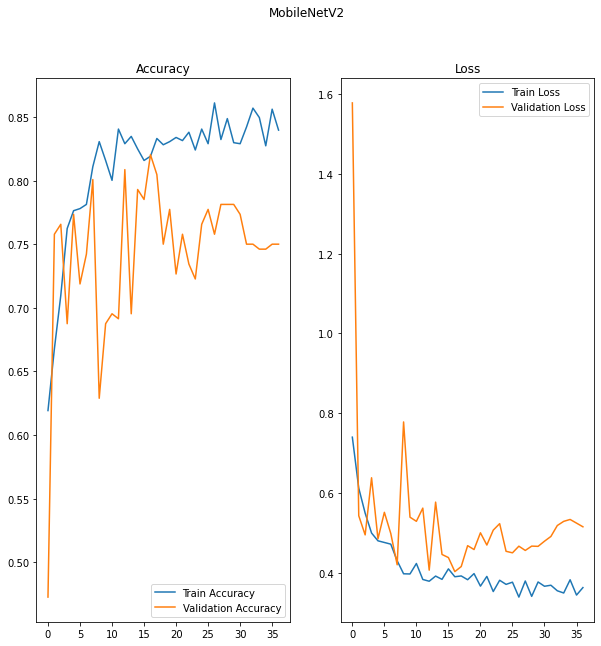

In [ ]:
# Plotting Training and Validation Accuracy
plot_history(history2,"MobileNetV2")

#7.Evaluation and conclusions


*When the learning curve for training loss that shows improvement and the learning curve for validation loss also shows improvement, but a large gap remains between both curves, we can conclude that we have an unrepresentative training dataset.* 

*Also,when the learning curve for training looks that achieves a good fit and the learning curve for validation loss shows noisy movements around the training loss or the validation loss is inferior than training loss, we can conclude that we have an unrepresentative validation dataset*". 

*This may occur if the training dataset has too few examples as compared to the validation dataset or viceversa*

Unrepresentative validation dataset implies that the ability of the model to generalize is very poor because the validation dataset does not provide enough information. While unrepresentative training dataset means that the training dataset does not provide sufficient information to learn the problem, relative to the validation dataset used to evaluate it.

Source [Jason Brownlee ](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)

Although RoCoLe has information to be able to classify in binary it is not enough for these two trained networks. In the article they explain that they have used other types of ML algorithms such as SVM. However, they don’t give more information nor results.

Anyway, the tutorial has been satisfactory to show all the essential steps to start analyzing a dataset using TensorFlow tools. It has been demonstrated, using visual tools, that this dataset is not optimal for a binary classification following the above steps.

Hope you liked it!